In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Data Preprocessing:

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
#filtered_data.head(3)

Number of data points in our data (525814, 10)


In [3]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID """, con)

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
display= pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductID""", con)

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [102]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [106]:
if os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    final_string_summary=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
        i+=1
        
    for sent in tqdm(final['Summary'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        
                    else:
                        continue
                else:
                    continue 
        str2 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string_summary.append(str2)
        i+=1
        
        
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    final['CleanedSummary']=final_string_summary
    final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:54<00:00, 6657.78it/s]


In [107]:
final.shape

(364171, 12)

In [109]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [110]:
with open('final.pkl', 'wb') as f:
        pickle.dump(final, f)

In [2]:
with open('final.pkl', 'rb') as f:
        final=pickle.load(f)

In [3]:
final.shape

(364171, 12)

In [4]:
final=final.sort_values('Time')

In [5]:
final= final.tail(364000)

In [6]:
fulltrain=final.head(291200)

test=final.tail(72800)

train=final.head(218400)

cv=final.tail(72800)

In [7]:
print(fulltrain["Score"].value_counts())
print(train["Score"].value_counts())
print(cv["Score"].value_counts())
print(test["Score"].value_counts())

1    246626
0     44574
Name: Score, dtype: int64
1    186835
0     31565
Name: Score, dtype: int64
1    60275
0    12525
Name: Score, dtype: int64
1    60275
0    12525
Name: Score, dtype: int64


In [8]:
train_scores=train["Score"]
cv_scores=cv["Score"]
test_scores=test["Score"]
full_train_scores=fulltrain["Score"]

In [9]:
print(test_scores.count())

72800


# BoW:

In [62]:
count_vect = CountVectorizer()#Convert a collection of text documents to a matrix of token counts
train_bow = count_vect.fit_transform(train["CleanedText"].values)
cv_bow = count_vect.transform(cv["CleanedText"].values)
test_bow = count_vect.transform(test["CleanedText"].values)
#full_train_bow=count_vect.fit_transform(fulltrain["CleanedText"].values)
#We use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data.
#We use transform() on the cv & test data because we use the scaling paramaters learned on the train data to scale the test data.

In [63]:
test_bow.shape

(72800, 54761)

# TFIDF:

In [13]:
tf_idf_vect = TfidfVectorizer()
train_tf_idf = tf_idf_vect.fit_transform(train['CleanedText'].values)
cv_tf_idf = tf_idf_vect.transform(cv['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(test['CleanedText'].values)

# NaviBayes with Bag of Words:

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
auc_scores = []
precision_scores=[]
recall_scores=[]
f1_scores=[]
hyperparameter=[]
for i in tqdm(range(1,21)):
    
    NB_bow = MultinomialNB(alpha=10**(i-10), fit_prior=True, class_prior=None)

    NB_bow.fit(train_bow, train_scores)

    predicted_bow_cv = NB_bow.predict(cv_bow)
   
    auc = roc_auc_score(cv_scores, predicted_bow_cv) * float(100)
    precision= precision_score(cv_scores, predicted_bow_cv) * float(100)
    recall = recall_score(cv_scores, predicted_bow_cv) * float(100)
    f1 = f1_score(cv_scores, predicted_bow_cv) * float(100)
    #f1-score is a harmonic mean of precision and recall
    auc_scores.append(int(auc))
    precision_scores.append(int(precision))
    recall_scores.append(int(recall))
    f1_scores.append(int(f1))
    
    hyperparameter.append(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  2.13it/s]


In [15]:
#hyperparameter.shape
#scores.shape
print(auc_scores)
print(precision_scores)
print(recall_scores)
print(f1_scores)
print(hyperparameter)

[78, 78, 78, 79, 79, 79, 80, 81, 81, 80, 61, 49, 50, 50, 50, 50, 50, 50, 50, 50]
[92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 86, 82, 82, 82, 82, 82, 82, 82, 82, 82]
[93, 93, 93, 93, 93, 93, 93, 93, 92, 94, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100]
[92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 92, 90, 90, 90, 90, 90, 90, 90, 90, 90]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


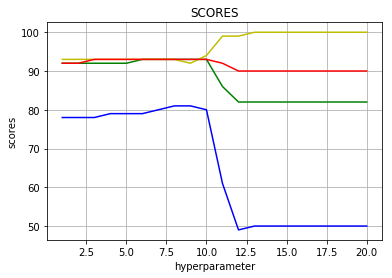

In [16]:
from matplotlib.ticker import NullFormatter 

plt.plot(hyperparameter,auc_scores,'b', hyperparameter, precision_scores,'g', hyperparameter,recall_scores,'y' , hyperparameter,f1_scores,'r')
plt.xlabel('hyperparameter')
plt.ylabel('scores')
plt.title('SCORES')

plt.grid()
plt.show()

#bule line is AUC score
#green line is precision score
#yellow line is recall score
#red line is f1-score

Observation: In the above graph we can see that AUC, precision, f1 scores are maximum at alpha=1 i.e, when i=8 the alpha=10**(8-10)=>alpha=0.01 

In [17]:
NB_bow_test = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)

NB_bow_test.fit(train_bow, train_scores)

predicted_test_labels = NB_bow_test.predict(test_bow)

auc = roc_auc_score(test_scores, predicted_test_labels) * float(100)
precision= precision_score(test_scores, predicted_test_labels) * float(100)
recall = recall_score(test_scores, predicted_test_labels) * float(100)
f1 = f1_score(test_scores, predicted_test_labels) * float(100)

print("AUC score on the test data:",auc)
print("precision score on the test data:",precision)
print("recall score on the test data:",recall)
print("f1 score on the test data:",f1)

AUC score on the test data: 81.13830903104616
precision score on the test data: 93.56377036333016
recall score on the test data: 93.09498133554541
f1 score on the test data: 93.32878717317544


obseration: On the test data we can see that the scores are slightly high

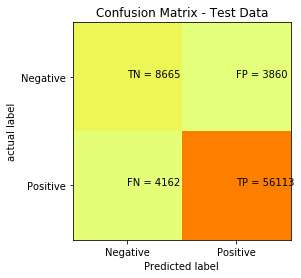

In [19]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(test_scores, predicted_test_labels)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()


Observation: In the confusion matrix we can see that                                                                            

->93.5% positive labels are correctly predicted                                                                                 

->67.5% negative labels are correctly predicted

# Feature importance with Bow:

In [65]:
bow_features=count_vect.get_feature_names()

feature_count = NB_bow_test.feature_count_

log_prob = NB_bow_test.feature_log_prob_


feature_prob = pd.DataFrame(log_prob,columns = bow_features)

feature_prob_tr = feature_prob.T

print("\n\n Top 10 Positive Features:",feature_prob_tr[1].sort_values(ascending = False)[0:10])

print("\n\n Top 10 negitive Features:",feature_prob_tr[0].sort_values(ascending = False)[0:10])



 Top 10 Positive Features: like      -4.435948
tast      -4.503586
good      -4.640306
flavor    -4.668156
love      -4.698535
great     -4.715245
use       -4.736983
one       -4.792957
tea       -4.855864
product   -4.877726
Name: 1, dtype: float64


 Top 10 negitive Features: tast      -4.199357
like      -4.285410
product   -4.446367
one       -4.720142
flavor    -4.784606
tri       -4.881099
would     -4.891219
good      -5.025381
coffe     -5.074260
use       -5.076730
Name: 0, dtype: float64


# NaviBayes with tfidf:

In [21]:
hyperparameter_tfidf = []
auc_scores_tfidf=[]
precision_scores_tfidf =[]
recall_scores_tfidf=[]
f1_scores_tfidf=[]
for i in tqdm(range(1,21)):
    
    NB_tfidf_cv = MultinomialNB(alpha=10**(i-10), fit_prior=True, class_prior=None)

    
    NB_tfidf_cv.fit(train_tf_idf, train_scores)

    predicted_tfidf_cv = NB_tfidf_cv.predict(cv_tf_idf)#[j: j+1000]))
        
    auc = roc_auc_score(cv_scores, predicted_tfidf_cv) * float(100)
    precision= precision_score(cv_scores, predicted_tfidf_cv) * float(100)
    recall = recall_score(cv_scores, predicted_tfidf_cv) * float(100)
    f1 = f1_score(cv_scores, predicted_tfidf_cv) * float(100)
    #f1-score is a harmonic mean of precision and recall
    auc_scores_tfidf.append(int(auc))
    precision_scores_tfidf.append(int(precision))
    recall_scores_tfidf.append(int(recall))
    f1_scores_tfidf.append(int(f1))
    #alpha=10**(i-5)
    hyperparameter_tfidf.append(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.21it/s]


In [22]:
print(auc_scores_tfidf)
print(precision_scores_tfidf)
print(recall_scores_tfidf)
print(f1_scores_tfidf)
print(hyperparameter_tfidf)

[61, 61, 61, 61, 61, 61, 61, 62, 61, 53, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50]
[86, 86, 86, 86, 86, 86, 86, 86, 86, 83, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]
[98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[92, 92, 92, 92, 92, 92, 92, 92, 92, 91, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


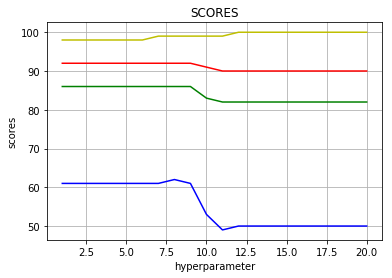

In [23]:
plt.plot(hyperparameter_tfidf,auc_scores_tfidf,'b', hyperparameter_tfidf, precision_scores_tfidf,'g', hyperparameter_tfidf,recall_scores_tfidf,'y' , hyperparameter_tfidf,f1_scores_tfidf,'r')
plt.ylabel('scores')
plt.xlabel('hyperparameter')
plt.title('SCORES')

plt.grid()
plt.show()


Observation: At the hyperparameter 8 we can see that all the scores are maximum 

In [24]:
NB_tfidf_test = MultinomialNB(alpha=10**(8-10), fit_prior=True, class_prior=None)

NB_tfidf_test.fit(train_tf_idf, train_scores)


predicted_labels_test_tfidf = NB_tfidf_test.predict(test_tf_idf)#[j: j+1000]))

auc_tfidf = roc_auc_score(test_scores, predicted_labels_test_tfidf) * float(100)
precision_tfidf= precision_score(test_scores, predicted_labels_test_tfidf) * float(100)
recall_tfidf = recall_score(test_scores, predicted_labels_test_tfidf) * float(100)
f1_tfidf = f1_score(test_scores, predicted_labels_test_tfidf) * float(100)

print("AUC score on the test data:",auc_tfidf)
print("precision score on the test data:",precision_tfidf)
print("recall score on the test data:",recall_tfidf)
print("f1 score on the test data:",f1_tfidf)

AUC score on the test data: 62.020364083115396
precision score on the test data: 86.39878586398785
recall score on the test data: 99.17046868519287
f1 score on the test data: 92.34512590761626


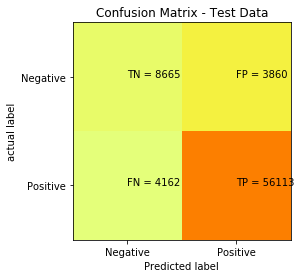

In [25]:

cm_tfidf = confusion_matrix(test_scores, predicted_labels_test_tfidf)


plt.imshow(cm_tfidf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
notations = np.arange(len(classNames))
plt.xticks(notations, classNames, rotation=360)
plt.yticks(notations, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()


Observation: In the confusion matrix we can see that                                                                            

->93.1% positive labels are correctly predicted                                                                                 

->74.9% negative labels are correctly predicted

# Feature importance with tfidf:

In [91]:
tfidf_features=tf_idf_vect.get_feature_names()

feature_count = NB_tfidf_test.feature_count_

log_prob = NB_tfidf_test.feature_log_prob_

feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)

feature_prob_tr = feature_prob.T

print("\n\n Top 10 Positive Features:",feature_prob_tr[1].sort_values(ascending = False)[0:10])

print("\n\n Top 10 Negitive Features:",feature_prob_tr[0].sort_values(ascending = False)[0:10])



 Top 10 Positive Features: great     -5.065157
love      -5.080484
tast      -5.138238
good      -5.140970
tea       -5.155387
like      -5.155475
flavor    -5.218388
coffe     -5.247307
product   -5.315511
use       -5.331382
Name: 1, dtype: float64


 Top 10 Negitive Features: tast      -4.829164
like      -4.980480
product   -5.023219
would     -5.331504
flavor    -5.351310
coffe     -5.355406
one       -5.364543
tri       -5.469748
buy       -5.490286
order     -5.497484
Name: 0, dtype: float64


In [51]:
log_prob.shape

(2, 54761)

In [52]:
len(tfidf_features)

54761


# Feature Engineering:

In feature engineering we combining the total avaliable text data i.e., summary and text data 

In [66]:
final["fulltext"] = final["CleanedText"] + final["CleanedSummary"]

In [67]:
print(final['Score'].value_counts())

1    306901
0     57099
Name: Score, dtype: int64


In [68]:
fe_fulltrain=final.head(291200)

fe_test=final.tail(72800)

fe_train=final.head(218400)

fe_cv=final.tail(72800)

In [69]:
fe_test["Score"].value_counts()

1    60275
0    12525
Name: Score, dtype: int64

In [70]:
fe_train_scores=fe_train["Score"]
fe_cv_scores=fe_cv["Score"]
fe_test_scores=fe_test["Score"]
fe_full_train_scores=fe_fulltrain["Score"]

In [71]:
fe_count_vect = CountVectorizer()#Convert a collection of text documents to a matrix of token counts
fe_train_bow = fe_count_vect.fit_transform(fe_train["fulltext"].values)
fe_cv_bow = fe_count_vect.transform(fe_cv["fulltext"].values)
fe_test_bow = fe_count_vect.transform(fe_test["fulltext"].values)
#fe_full_train_bow = fe_count_vect.fit_transform(fe_fulltrain["fulltext"].values)

In [72]:
fe_test_bow.shape

(72800, 173618)

In [73]:
fe_tfidf_vect = TfidfVectorizer()
fe_train_tf_idf = fe_tfidf_vect.fit_transform(fe_train['fulltext'].values)
fe_cv_tf_idf = fe_tfidf_vect.transform(fe_cv['fulltext'].values)
fe_test_tf_idf = fe_tfidf_vect.transform(fe_test['fulltext'].values)

In [105]:
auc_scores = []
precision_scores=[]
recall_scores=[]
f1_scores=[]
hyperparameter=[]
for i in tqdm(range(1,21)):
    
    NB_bow = MultinomialNB(alpha=10**(i-10), fit_prior=True, class_prior=None)

    NB_bow.fit(fe_train_bow, fe_train_scores)

    predicted_bow_cv = NB_bow.predict(fe_cv_bow)
   
    auc = roc_auc_score(fe_cv_scores, predicted_bow_cv) * float(100)
    precision= precision_score(fe_cv_scores, predicted_bow_cv) * float(100)
    recall = recall_score(fe_cv_scores, predicted_bow_cv) * float(100)
    f1 = f1_score(fe_cv_scores, predicted_bow_cv) * float(100)
    #f1-score is a harmonic mean of precision and recall
    auc_scores.append(int(auc))
    precision_scores.append(int(precision))
    recall_scores.append(int(recall))
    f1_scores.append(int(f1))
    
    hyperparameter.append(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35it/s]


In [106]:
print(auc_scores)
print(precision_scores)
print(recall_scores)
print(f1_scores)
print(hyperparameter)

[78, 78, 79, 79, 79, 80, 81, 82, 83, 77, 50, 49, 50, 50, 50, 50, 50, 50, 50, 50]
[92, 92, 92, 92, 92, 93, 93, 93, 94, 91, 83, 82, 82, 82, 82, 82, 82, 82, 82, 82]
[94, 94, 94, 94, 94, 94, 94, 93, 93, 96, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100]
[93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


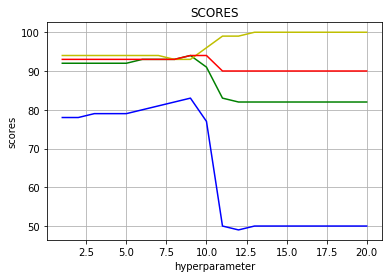

In [107]:
plt.plot(hyperparameter,auc_scores,'b', hyperparameter, precision_scores,'g', hyperparameter,recall_scores,'y' , hyperparameter,f1_scores,'r')
plt.xlabel('hyperparameter')
plt.ylabel('scores')
plt.title('SCORES')

plt.grid()
plt.show()

In [108]:
predicted_test_labels=[]
fe_NB_bow_test = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)

fe_NB_bow_test.fit(fe_train_bow, fe_train_scores)

predicted_test_labels = fe_NB_bow_test.predict(fe_test_bow)

auc = roc_auc_score(fe_test_scores, predicted_test_labels) * float(100)
precision= precision_score(fe_test_scores, predicted_test_labels) * float(100)
recall = recall_score(fe_test_scores, predicted_test_labels) * float(100)
f1 = f1_score(fe_test_scores, predicted_test_labels) * float(100)

print("AUC score on the test data:",auc)
print("precision score on the test data:",precision)
print("recall score on the test data:",recall)
print("f1 score on the test data:",f1)

AUC score on the test data: 83.07890564784988
precision score on the test data: 94.21773804172285
recall score on the test data: 93.88635420987143
f1 score on the test data: 94.05175422559789


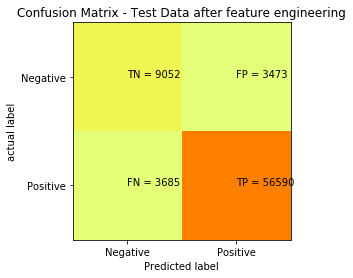

In [109]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(fe_test_scores, predicted_test_labels)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data after feature engineering')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()


In [82]:
fe_Bow_features=fe_count_vect.get_feature_names()

feature_count = fe_NB_bow_test.feature_count_

log_prob = fe_NB_bow_test.feature_log_prob_

feature_prob = pd.DataFrame(log_prob, columns = fe_Bow_features)

feature_prob_tr = feature_prob.T

print("\n\n Top 10 Positive Features:",feature_prob_tr[1].sort_values(ascending = False)[0:10])

print("\n\n Top 10 Negitive Features:",feature_prob_tr[0].sort_values(ascending = False)[0:10])



 Top 10 Positive Features: like      -4.475078
tast      -4.488754
good      -4.634654
flavor    -4.682549
great     -4.705985
love      -4.709975
use       -4.784382
tea       -4.789121
one       -4.850800
product   -4.878519
Name: 1, dtype: float64


 Top 10 Negitive Features: tast      -4.190916
like      -4.292515
product   -4.502305
one       -4.785767
flavor    -4.793956
would     -4.937566
tri       -4.939405
good      -5.047848
coffe     -5.078986
use       -5.126049
Name: 0, dtype: float64


In [110]:
hyperparameter_tfidf = []
auc_scores_tfidf=[]
precision_scores_tfidf =[]
recall_scores_tfidf=[]
f1_scores_tfidf=[]
for i in tqdm(range(1,21)):
    
    fe_NB_tfidf_cv = MultinomialNB(alpha=10**(i-10), fit_prior=True, class_prior=None)

    
    fe_NB_tfidf_cv.fit(fe_train_tf_idf, fe_train_scores)

    predicted_tfidf_cv = fe_NB_tfidf_cv.predict(fe_cv_tf_idf)
        
    auc = roc_auc_score(fe_cv_scores, predicted_tfidf_cv) * float(100)
    precision= precision_score(fe_cv_scores, predicted_tfidf_cv) * float(100)
    recall = recall_score(fe_cv_scores, predicted_tfidf_cv) * float(100)
    f1 = f1_score(fe_cv_scores, predicted_tfidf_cv) * float(100)
    #f1-score is a harmonic mean of precision and recall
    auc_scores_tfidf.append(int(auc))
    precision_scores_tfidf.append(int(precision))
    recall_scores_tfidf.append(int(recall))
    f1_scores_tfidf.append(int(f1))
    #alpha=10**(i-5)
    hyperparameter_tfidf.append(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


In [111]:
print(auc_scores_tfidf)
print(precision_scores_tfidf)
print(recall_scores_tfidf)
print(f1_scores_tfidf)
print(hyperparameter_tfidf)

[65, 65, 65, 65, 65, 65, 65, 65, 61, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
[87, 87, 87, 87, 87, 87, 87, 87, 86, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]
[98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[92, 92, 92, 92, 92, 92, 92, 92, 92, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


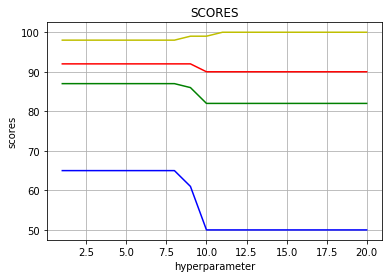

In [112]:
plt.plot(hyperparameter_tfidf,auc_scores_tfidf,'b', hyperparameter_tfidf, precision_scores_tfidf,'g', hyperparameter_tfidf,recall_scores_tfidf,'y' , hyperparameter_tfidf,f1_scores_tfidf,'r')
plt.ylabel('scores')
plt.xlabel('hyperparameter')
plt.title('SCORES')

plt.grid()
plt.show()

In [113]:
fe_NB_tfidf_test = MultinomialNB(alpha=10**(1-10), fit_prior=True, class_prior=None)

fe_NB_tfidf_test.fit(fe_train_tf_idf, fe_train_scores)


fe_predicted_labels_test_tfidf = fe_NB_tfidf_test.predict(fe_test_tf_idf)#[j: j+1000]))

auc_tfidf = roc_auc_score(fe_test_scores, fe_predicted_labels_test_tfidf) * float(100)
precision_tfidf= precision_score(fe_test_scores, fe_predicted_labels_test_tfidf) * float(100)
recall_tfidf = recall_score(fe_test_scores, fe_predicted_labels_test_tfidf) * float(100)
f1_tfidf = f1_score(fe_test_scores, fe_predicted_labels_test_tfidf) * float(100)

print("AUC score on the test data:",auc_tfidf)
print("precision score on the test data:",precision_tfidf)
print("recall score on the test data:",recall_tfidf)
print("f1 score on the test data:",f1_tfidf)

AUC score on the test data: 65.10472708668105
precision score on the test data: 87.42663690256198
recall score on the test data: 98.11364579012857
f1 score on the test data: 92.46235869854125


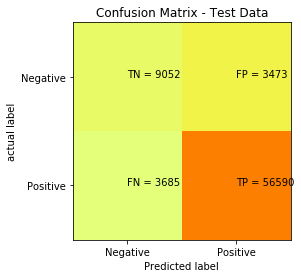

In [114]:

cm_tfidf = confusion_matrix(fe_test_scores, fe_predicted_labels_test_tfidf)


plt.imshow(cm_tfidf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
notations = np.arange(len(classNames))
plt.xticks(notations, classNames, rotation=360)
plt.yticks(notations, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()


In [115]:
tfidf_features=fe_tfidf_vect.get_feature_names()

feature_count = fe_NB_tfidf_test.feature_count_

log_prob = fe_NB_tfidf_test.feature_log_prob_

feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)

feature_prob_tr = feature_prob.T

print("\n\n Top 10 Positive Features:",feature_prob_tr[1].sort_values(ascending = False)[0:10])

print("\n\n Top 10 Negitive Features:",feature_prob_tr[0].sort_values(ascending = False)[0:10])



 Top 10 Positive Features: tea       -5.126359
great     -5.178017
love      -5.195613
tast      -5.203733
good      -5.237721
coffe     -5.239654
like      -5.263852
flavor    -5.303077
product   -5.389410
use       -5.443653
Name: 1, dtype: float64


 Top 10 Negitive Features: tast      -4.884538
like      -5.037380
product   -5.143076
coffe     -5.409416
flavor    -5.409494
would     -5.426959
one       -5.473074
tri       -5.561136
order     -5.625805
buy       -5.663892
Name: 0, dtype: float64


# CONCLUSION:

In the above table we can see that the classification correct positive's and negitive's are incresses when feature engineering. So, out of all positive points 94.5% points are correctly classified similarly out of all negitive points 71.0% points are correctly predicted.       